### Introduction

In this study, I aim to analyze and compare the voting preferences in different regions of Poland based on their historical backgrounds. The data set used for this analysis pertains to the second round of the 2020 Polish presidential election. In this round, the two candidates were distinctly categorized as "liberal" and "conservative," making the proportion of votes for Andrzej Sebastian Duda—a conservative candidate—a valuable metric for understanding voting preferences across various regions.

Poland's territory has been shaped by various geopolitical events, leading to four distinct groups of regions with unique historical contexts:

1. **Territories Acquired Upon Independence from Austria**: Regions that were part of the Austro-Hungarian Empire before Poland regained its independence in 1918.
2. **Territories Acquired Upon Independence from Russia**: Regions that were under Russian control prior to Poland's independence.
3. **Territories from the German Empire**: Areas that were once part of the German Empire before World War I and incorporated into Poland following its independence.
4. **Territories Received from Germany After World War II**: Regions that Poland received from Germany after World War II, which were previously German-inhabited.

My analysis aims to explore the distribution of voting preferences for Andrzej Sebastian Duda across these four historical groups and assess the influence of historical context on voting patterns. To achieve this, I will:

1. **Draw Histograms**: Visualize the distribution of voting proportions for Andrzej Sebastian Duda across the four historical groups by plotting histograms to gain an initial understanding of the data.

2. **Test for Normality**: Utilize the Shapiro-Wilk test to determine whether the distributions of voting proportions in each group conform to a normal distribution.

3. **Compare Distributions**: Compare normally distributed groups using a T-test, otherwise apply the Kolmogorov-Smirnov (KS) test to compare the distributions of voting preferences between all pairs of groups, assessing whether the distributions differ significantly.

4. **Linear Regression Analysis**: Calculate the distance of each region to the border between historical groups and use linear regression to explore the relationship between this distance and the proportion of votes for Andrzej Duda.

Through these steps, I aim to uncover patterns and insights into how historical affiliations and geographical proximities influence voting behaviors in different regions of Poland.


### Data Import
Let's first import the required libraries and load files with data.

In [45]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import geopandas as gpd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# load CSV file
file_path = 'classified_powiat_round2.csv'
df = pd.read_csv(file_path)
# load GeoJSON file
gdf = gpd.read_file('polish_provinces.geojson')
gdf['centroid_lon'] = gdf.centroid.x
gdf['centroid_lat'] = gdf.centroid.y


# merge the CSV with the GeoJSON based on 'Kod TERYT' and 'teryt_code'
df = df.merge(gdf[['teryt_code', 'centroid_lon', 'centroid_lat']], left_on='Kod TERYT', right_on='teryt_code', how='left')

# calculate the proportion of votes for Andrzej Sebastian DUDA
df['Duda_Proportion'] = df['Andrzej Sebastian DUDA'] / df['Liczba głosów ważnych oddanych łącznie na wszystkich kandydatów']
groups = df['Group'].unique()

### Drawing a histogram
Let's begin with drawing a plot to get the initial idea of the distribution.

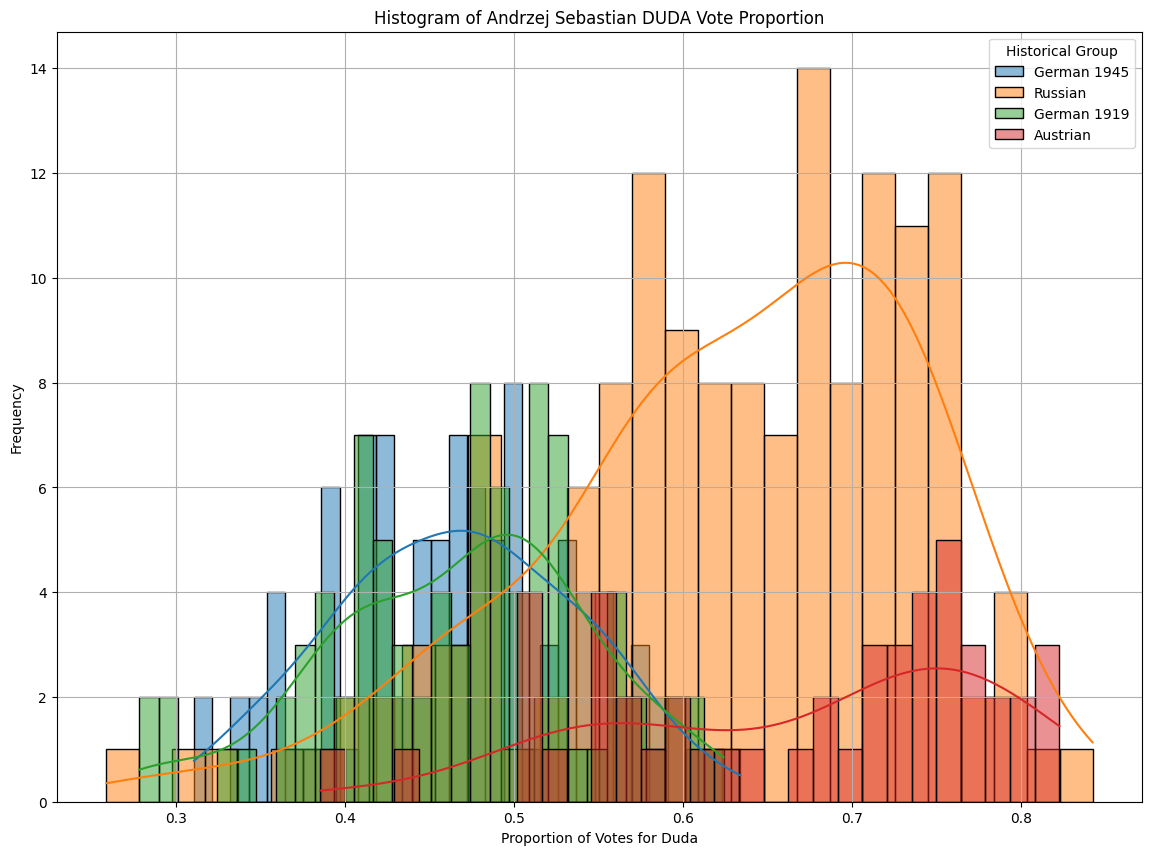

In [39]:
plt.figure(figsize=(14, 10))
for group in groups:
    sns.histplot(df[df['Group'] == group]['Duda_Proportion'], bins=30, kde=True, label=group)

plt.title('Histogram of Andrzej Sebastian DUDA Vote Proportion')
plt.xlabel('Proportion of Votes for Duda')
plt.ylabel('Frequency')
plt.legend(title='Historical Group')
plt.grid(True)
plt.show()

### Checking for normality

As we can see, although the distribution of groups "Russian" and "Austrian" do not resemble a normal distribution, the distribution in counties in "German" groups do resemble a normal distribution, and even more, a similar one. It will therefore make sense to test those distributions for normality.



In [42]:
# Check if distributions are normal
normality_results = {}
for group in groups:
    data = df[df['Group'] == group]['Duda_Proportion']
    stat, p_value = stats.shapiro(data)
    normality_results[group] = (stat, p_value)

# Print normality test results
print("\nNormality Test Results (Shapiro-Wilk Test):")
for group, result in normality_results.items():
    stat, p_value = result
    print(f"Group: {group} | Shapiro-Wilk Statistic: {stat:.4f} | p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("  The distribution is not normal.")
    else:
        print("  The distribution is normal.")


Normality Test Results (Shapiro-Wilk Test):
Group: German 1945 | Shapiro-Wilk Statistic: 0.9918 | p-value: 0.8168
  The distribution is normal.
Group: Russian | Shapiro-Wilk Statistic: 0.9572 | p-value: 0.0002
  The distribution is not normal.
Group: German 1919 | Shapiro-Wilk Statistic: 0.9818 | p-value: 0.2525
  The distribution is normal.
Group: Austrian | Shapiro-Wilk Statistic: 0.9205 | p-value: 0.0031
  The distribution is not normal.


So, for both German groups we indeed cannot reject the null hypothesis of them being normally distributed. 


# Perform T-test
Given both those groups are probably normally distributed, let's perform a T-test between them to see if they belong to the same distribution.


In [43]:
# filter data for the 'german1919' and 'german1945' groups
german1919_data = df[df['Group'] == 'German 1919']['Duda_Proportion']
german1945_data = df[df['Group'] == 'German 1945']['Duda_Proportion']

# Perform T-test
t_stat, t_p_value = stats.ttest_ind(german1919_data, german1945_data)
print("\nT-Test Results (german1919 vs german1945):")
print(f"T Statistic: {t_stat:.4f} | p-value: {t_p_value:.4f}")

if t_p_value < 0.05:
    # reject null hypothesis
    print("  The means of the two groups are significantly different.")
else:
    # fail to reject null hypothesis
    print("  The means of the two groups are not significantly different.")



T-Test Results (german1919 vs german1945):
T Statistic: 0.0747 | p-value: 0.9405
  The means of the two groups are not significantly different.


Despite the substantial historical differences between these regions—where the area of Poland acquired from Germany after World War I was predominantly Polish, while the area gained after World War II, marked as "German 1945," was previously inhabited by Germans and only began to be populated by Poles after the war—the statistical analysis indicates a lack of significant difference.

After conducting a t-test with the null hypothesis that the two groups come from the same distribution, we obtained a very low t-statistic value of 0.07 and a p-value of 0.94. This suggests that the two groups likely belong to the same distribution. 



### KS test
Although we have found that the distributions of other groups("Russian" and "Austrian") do not follow a normal distribution, we can still compare them using the Kolmogorov-Smirnov test. This non-parametric test does not assume normality and allows us to compare the empirical distributions of the two groups to assess if they come from the same distribution.


In [41]:
# perform KS test on all pairs of groups

ks_results = []

for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        group1 = groups[i]
        group2 = groups[j]
        data1 = df[df['Group'] == group1]['Duda_Proportion']
        data2 = df[df['Group'] == group2]['Duda_Proportion']
        ks_stat, ks_p_value = stats.ks_2samp(data1, data2)
        ks_results.append((group1, group2, ks_stat, ks_p_value))

# print KS test results
print("Kolmogorov-Smirnov Test Results:")
for result in ks_results:
    print(f"Groups: {result[0]} vs {result[1]} | KS Statistic: {result[2]:.4f} | p-value: {result[3]:.4f}")

Kolmogorov-Smirnov Test Results:
Groups: German 1945 vs Russian | KS Statistic: 0.6819 | p-value: 0.0000
Groups: German 1945 vs German 1919 | KS Statistic: 0.0874 | p-value: 0.8283
Groups: German 1945 vs Austrian | KS Statistic: 0.7113 | p-value: 0.0000
Groups: Russian vs German 1919 | KS Statistic: 0.6834 | p-value: 0.0000
Groups: Russian vs Austrian | KS Statistic: 0.2613 | p-value: 0.0112
Groups: German 1919 vs Austrian | KS Statistic: 0.7064 | p-value: 0.0000


After conducting the Kolmogorov-Smirnov test, we found that all group pairs, except for the two German groups (German 1945 and German 1919), have significantly different distributions. For other groups p value is very close to 0 which means we can reject the null hypothesis of them being of same distribution.

### Linear regression
The following code cells will be dedicated to first calculate distance to border for each county(powiat). The distance to border is essentially shortest distance to any another county from the opposite group.
This data is then used for building a linear regression with three lines: two of them fitting into the separate group, the third one is the common line that fits the whole dataset containing both groups.

In [46]:
def simplified_distance(lon1, lat1, lon2, lat2):
    # approximate latitude and longitude to kilometers conversion
    km_per_degree_lat = 111.0 
    km_per_degree_lon = 111.0 * np.cos(np.radians((lat1 + lat2) / 2))
    
    # differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # distance
    distance = np.sqrt((dlat * km_per_degree_lat)**2 + (dlon * km_per_degree_lon)**2)
    return distance
# define groups
austria_russia_groups = ['Austrian', 'Russian']
german_groups = ['German 1919', 'German 1945']

# create dataframes for each group
austria_russia_df = df[df['Group'].isin(austria_russia_groups)]
german_df = df[df['Group'].isin(german_groups)]

# initialize distance
df['distance_to_border'] = np.nan

# calculate distances for Austria and Russia
for index, row in austria_russia_df.iterrows():
    distance_to_german = german_df.apply(
        lambda x: simplified_distance(row['centroid_lon'], row['centroid_lat'], x['centroid_lon'], x['centroid_lat']), 
        axis=1
    )
    min_distance = distance_to_german.min()
    df.loc[index, 'distance_to_border'] = min_distance

# calculate distances for German groups
for index, row in german_df.iterrows():
    distance_to_austria_russia = austria_russia_df.apply(
        lambda x: simplified_distance(row['centroid_lon'], row['centroid_lat'], x['centroid_lon'], x['centroid_lat']), 
        axis=1
    )
    min_distance = distance_to_austria_russia.min()
    # write down distance as negative for proper comparison
    df.loc[index, 'distance_to_border'] = -min_distance

# preview the results
print(df[['Kod TERYT', 'Powiat', 'distance_to_border']].head())




Updated DataFrame with Distance to Border:
   Kod TERYT          Powiat  distance_to_border
0      20100   bolesławiecki         -169.244202
1      20200  dzierżoniowski         -127.530505
2      20300       głogowski         -121.924055
3      20400        górowski          -91.846349
4      20500        jaworski         -151.940491


Missing values in dataframe: distance_to_border    0
Duda_Proportion       0
dtype: int64


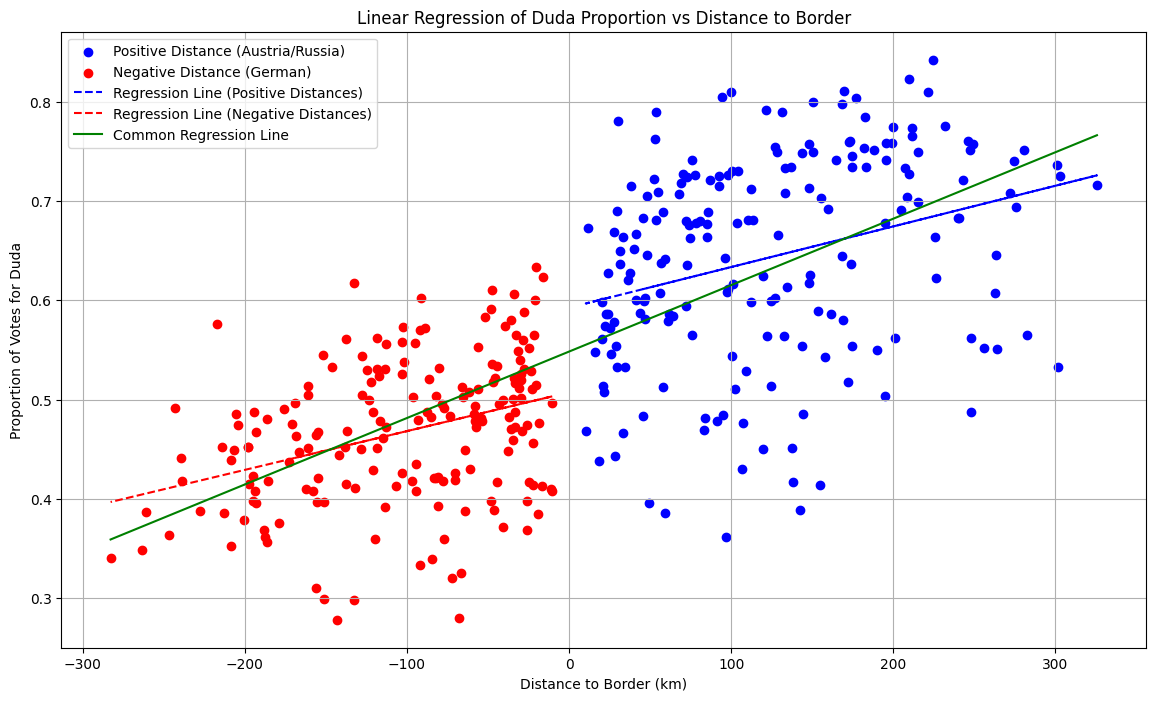

In [30]:

# drop rows with missing values in relevant columns
df = df.dropna(subset=['distance_to_border', 'Duda_Proportion'])


# filter data for linear regression
positive_df = df[df['distance_to_border'] > 0]  # Positive distances
negative_df = df[df['distance_to_border'] < 0]  # Negative distances

y_pred_pos = y_pred_neg = y_pred_all = None



# prepare the data for positive distances regression
X_pos = positive_df[['distance_to_border']].values.reshape(-1, 1)
y_pos = positive_df['Duda_Proportion'].values
model_pos = LinearRegression().fit(X_pos, y_pos)
y_pred_pos = model_pos.predict(X_pos)

# prepare data for negative distances regression
X_neg = negative_df[['distance_to_border']].values.reshape(-1, 1)
y_neg = negative_df['Duda_Proportion'].values
model_neg = LinearRegression().fit(X_neg, y_neg)
y_pred_neg = model_neg.predict(X_neg)


# prepare common regression
X_all = df[['distance_to_border']].values.reshape(-1, 1)
y_all = df['Duda_Proportion'].values
model_all = LinearRegression().fit(X_all, y_all)
y_pred_all = model_all.predict(X_all)

# predict values for regression lines over the full range
distance_range = np.linspace(df['distance_to_border'].min(), df['distance_to_border'].max(), 100).reshape(-1, 1)

# predict for common regression line
y_pred_all_range = model_all.predict(distance_range)

# plot
plt.figure(figsize=(14, 8))
plt.scatter(positive_df['distance_to_border'], positive_df['Duda_Proportion'], color='blue', label='Positive Distance (Austria/Russia)')
plt.scatter(negative_df['distance_to_border'], negative_df['Duda_Proportion'], color='red', label='Negative Distance (German)')
if y_pred_pos is not None:
    plt.plot(positive_df[['distance_to_border']], y_pred_pos, color='blue', linestyle='--', label='Regression Line (Positive Distances)')

if y_pred_neg is not None:
    plt.plot(negative_df[['distance_to_border']], y_pred_neg, color='red', linestyle='--', label='Regression Line (Negative Distances)')
plt.plot(distance_range, y_pred_all_range, color='green', linestyle='-', label='Common Regression Line')
plt.title('Linear Regression of Duda Proportion vs Distance to Border')
plt.xlabel('Distance to Border (km)')
plt.ylabel('Proportion of Votes for Duda')
plt.legend()
plt.grid(True)
plt.show()




### Analysis of linear regression.
1. **Distance as a Predictor**: It looks like distance to the border is indeed a meaningful predictor for voting outcome. If regions closer to one group consistently vote differently from those farther away, this suggests that proximity to historical divisions impacts voting preferences.

2. **Difference in Slopes**: The fact that the slope of the regression line within the groups differs from the overall slope suggests that there are distinct dynamics at play within each group. It indicates that there are separate underlying relationships between the distance and voting outcome for the two historical regions, rather than a simple continuous trend across all regions.

3. **Two Separate Groups**:My conclusion is that the counties belong to two distinct groups rather than being part of a continuous scale. It seems reasonable since the regression analysis reveals significantly different slopes for each group. This implies that the historical and geographical divisions create distinct voting behaviors, not just a gradual shift across a single continuum.


### Conclusions

I have used the tools of statistical analysis to investigate the voting patterns in the 2020 Polish presidential election.

Drawing a histogram of the proportion of votes for Andrzej Sebastian DUDA, I have observed that the distributions of the votes are different for different historical groups.

From the histogram I have noticed that German groups are very similar and also have a chance of being normally distributed.

After performing the Shapiro-Wilk normality test, I have found that the distributions of the votes are indeed normal for the German groups, and not normal for the other groups.

Knowing that German groups are similar, I have performed a T-test to compare the means of the two groups, and found that the means are not significantly different.

I have also performed the Kolmogorov-Smirnov test to compare the distributions of the votes between all pairs of groups. The results show that the distributions are significantly different for all pairs except already mentioned pair German1919 and German1945.

Finally, I have analyzed the relationship between the proportion of votes for Duda and the distance to the border. For this purpose I have put two German groups into one, and put Austrian and Russian groups together. I have found that the closer the county is to the border, the closer it is to counties from the opposite historical group. However, the regression for the separate groups has a less steep slope than the regression for the combined data. This suggests that the groups have different voting patterns and that the combined regression may not be the best model for the data. Therefore, the division between those two groups is indeed significant and the obtained results of the previous tests cannot be reduced to some simple East-West division that fits a single line on the regression. 